In [ ]:
import requests
import urllib.request
import time
import json
import community
import numpy as np
import pandas as pd
from urllib.request import urlopen

from tqdm import tqdm
from collections import Counter
from networkx.readwrite import json_graph

import multiprocessing

#pd.set_option('display.max_colwidth', None)
import networkx as nx
import matplotlib.pyplot as plt

import json
import re
from itertools import combinations

import seaborn as sns

# Obtención del detalle de las tesis

In [ ]:
df_thesis_pre = pd.read_csv("thesis_unmsm.csv", sep="|")
print(df_thesis_pre.shape)
df_thesis_pre.head(1)

(15392, 10)


,id,thesis_type,title,url,author,advisor,year,university,right,keyword
0,3161802,bachelorThesis,Análisis hidrogeológico conceptual y propuesta...,https://renati.sunedu.gob.pe/handle/sunedu/316...,"Contreras Gutiérrez, Efrain Jhiaromir","Mogrovejo Gutiérrez, Rubén Esaú",2022,Universidad Nacional Mayor de San Marcos,openAccess,"Mecánica de suelos, Aguas subterráneas"


In [ ]:
##### PRUEBA
#thesis_id_to_modify = 3161844

# Nuevas palabras clave
#new_keywords = ['Seguridad industrial, Accidentes de trabajo, Neuroprotección']

# Modificar las palabras clave en el DataFrame
#df_thesis_pre.loc[df_thesis_pre['id'] == thesis_id_to_modify, 'keyword'] = new_keywords

# Imprimir el DataFrame después de la modificación
#print(df_thesis_pre)


##Grafo

In [ ]:
df_thesis_pre.sample(3)

,id,thesis_type,title,url,author,advisor,year,university,right,keyword
827,2874303,bachelorThesis,Una descripción de la negación en la lengua ca...,https://renati.sunedu.gob.pe/handle/sunedu/287...,"Ayala Cornejo, Karla Fransheska","Alonzo Sutta, Alicia Nidia",2020,Universidad Nacional Mayor de San Marcos,openAccess,"Lengua caquinte, Lengua caquinte - Morfología,..."
12736,2885287,masterThesis,Caracterización geomecánica del macizo rocoso ...,https://renati.sunedu.gob.pe/handle/sunedu/288...,"Herrera Carranza, Editta","Solórzano Poma, Lloyd Williams",2020,Universidad Nacional Mayor de San Marcos,openAccess,"Geología - Perú - Puno (Dpto.), Geomorfología ..."
14794,2878179,bachelorThesis,Actitudes y preferencias hacia los videojuegos...,https://renati.sunedu.gob.pe/handle/sunedu/287...,"Chu Huerta, César Augusto","Arenas Iparraguirre, Carlos Alberto",2017,Universidad Nacional Mayor de San Marcos,closedAccess,"Videojuegos - Perú - Aspectos psicológicos, Es..."


In [ ]:
################################################
######Sólo para la prueba de 1k registros
################################################
G = nx.DiGraph()

# Agregar nodos al grafo (+atributos)
for index, row in df_thesis_pre.iterrows():
    # Utiliza expresiones regulares para dividir las palabras clave
    keywords = re.split(r',\s*', row['keyword'])
    node_data = {'title': row['title'], 'year': row['year'], 'university': row['university'], 'right': row['right'], 'keyword': keywords}
    G.add_node(row['id'], **node_data)

# Conexiones basadas en las palabras clave compartidas
for node1, node2 in combinations(G.nodes, 2):
    if G.has_node(node1) and G.has_node(node2):
        keywords_i = set(G.nodes[node1]['keyword'])
        keywords_j = set(G.nodes[node2]['keyword'])

        # Verifica si comparten al menos una palabra clave específica
        if any(keyword in keywords_j for keyword in keywords_i):
            G.add_edge(node1, node2)

In [ ]:
print (G)

DiGraph with 15392 nodes and 27968 edges


# Grafo 1: Tesis de Maestría || Año 2022

In [ ]:
#Tesis Maestría || Año: 2022
filtros = df_thesis_pre[ (df_thesis_pre['year'] == 2022) &
                             (df_thesis_pre['thesis_type'] == 'masterThesis')]

# Crea un nuevo DataFrame con las filas filtradas
df_thesis_Master2022 = pd.DataFrame(filtros)

In [ ]:
G1 = nx.Graph()

# Agrega nodos al grafo con atributos
for index, row in df_thesis_Master2022.iterrows():
    # Utiliza expresiones regulares para dividir las palabras clave
    keywords = re.split(r',\s*', row['keyword'])
    node_data = {'title': row['title'], 'year': row['year'], 'university': row['university'], 'right': row['right'], 'keyword': keywords}
    G1.add_node(row['id'], **node_data)

# Crea conexiones basadas en palabras clave compartidas
for node1, node2 in combinations(G1.nodes, 2):
    if G1.has_node(node1) and G1.has_node(node2):
        keywords_i = set(G1.nodes[node1]['keyword'])
        keywords_j = set(G1.nodes[node2]['keyword'])

        # Verifica si comparten al menos una palabra clave específica
        if any(keyword in keywords_j for keyword in keywords_i):
            G1.add_edge(node1, node2)

In [ ]:
unique_right_values = df_thesis_Master2022['right'].unique()
print(unique_right_values)

['openAccess' 'embargoedAccess']


In [ ]:
filtered_df = df_thesis_Master2022.loc[df_thesis_Master2022['right'] == 'closedAccess']
print(filtered_df)

Empty DataFrame
Columns: [id, thesis_type, title, url, author, advisor, year, university, right, keyword]
Index: []


In [ ]:
print (G1)

Graph with 355 nodes and 570 edges


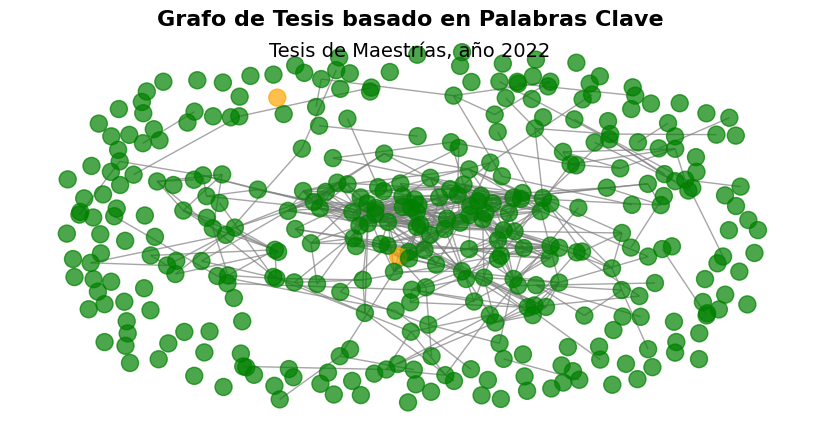

Graph with 355 nodes and 570 edges


In [ ]:
#pos = nx.kamada_kawai_layout(G1)
pos = nx.spring_layout(G1, k=0.15, iterations=20)
# k controls the distance between the nodes and varies between 0 and 1
# iterations is the number of times simulated annealing is run
# default k=0.1 and iterations=50

#Colores a los nodos según los derechos (right)
node_colors = []
for node in G1.nodes:
    if G1.nodes[node]['right'] == 'openAccess':
        node_colors.append('green')
    elif G1.nodes[node]['right'] == 'closedAccess':
        node_colors.append('red')
    elif G1.nodes[node]['right'] == 'embargoedAccess':
        node_colors.append('orange')

plt.figure(figsize=(8, 4))
nx.draw(G1, pos, with_labels=False, node_color=node_colors, font_size=8, font_color='black', node_size=150, edge_color='gray', alpha=0.7)

plt.title("Grafo de Tesis basado en Palabras Clave", fontsize=16, fontweight='bold')
plt.suptitle("Tesis de Maestrías, año 2022", fontsize=14)

plt.show()
print (G1)

# Grafo 1.2: Tesis de Doctorado || Año 2022

In [ ]:
#Tesis Doctorado || Año: 2022
filtros = df_thesis_pre[(df_thesis_pre['year'] == 2022) &
                             (df_thesis_pre['thesis_type'] == 'doctoralThesis')]

# Crea un nuevo DataFrame con las filas filtradas
df_thesis_Doc2022 = pd.DataFrame(filtros)

In [ ]:
G1_2 = nx.Graph()

# Agrega nodos al grafo con atributos
for index, row in df_thesis_Doc2022.iterrows():
    # Utiliza expresiones regulares para dividir las palabras clave
    keywords = re.split(r',\s*', row['keyword'])
    node_data = {'title': row['title'], 'year': row['year'], 'university': row['university'], 'right': row['right'], 'keyword': keywords}
    G1_2.add_node(row['id'], **node_data)

# Crea conexiones basadas en palabras clave compartidas
for node1, node2 in combinations(G1_2.nodes, 2):
    if G1_2.has_node(node1) and G1_2.has_node(node2):
        keywords_i = set(G1_2.nodes[node1]['keyword'])
        keywords_j = set(G1_2.nodes[node2]['keyword'])

        # Verifica si comparten al menos una palabra clave específica
        if any(keyword in keywords_j for keyword in keywords_i):
            G1_2.add_edge(node1, node2)

In [ ]:
unique_right_values = df_thesis_Doc2022['right'].unique()
print(unique_right_values)

['openAccess' 'embargoedAccess']


In [ ]:
print (G1_2)

Graph with 94 nodes and 21 edges


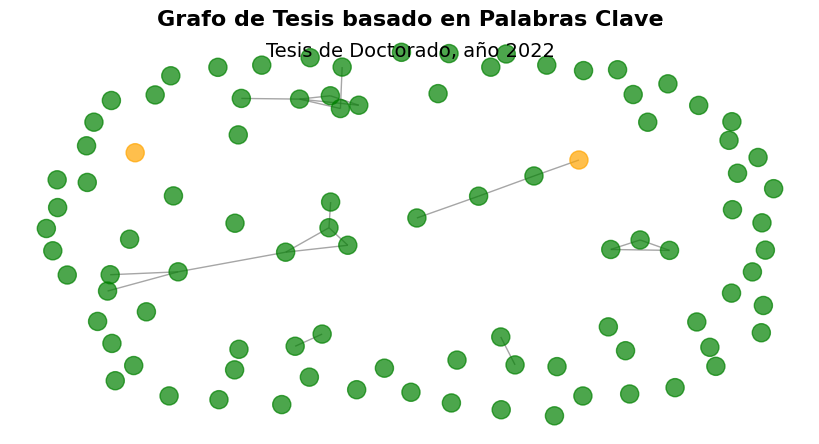

Graph with 94 nodes and 21 edges


In [ ]:
#pos = nx.kamada_kawai_layout(G1)
pos = nx.spring_layout(G1_2, k=0.15, iterations=20)
# k controls the distance between the nodes and varies between 0 and 1
# iterations is the number of times simulated annealing is run
# default k=0.1 and iterations=50

#Colores a los nodos según los derechos (right)
node_colors = []
for node in G1_2.nodes:
    if G1_2.nodes[node]['right'] == 'openAccess':
        node_colors.append('green')
    elif G1_2.nodes[node]['right'] == 'closedAccess':
        node_colors.append('red')
    elif G1_2.nodes[node]['right'] == 'embargoedAccess':
        node_colors.append('orange')

plt.figure(figsize=(8, 4))
nx.draw(G1_2, pos, with_labels=False, node_color=node_colors, font_size=8, font_color='black', node_size=170, edge_color='gray', alpha=0.7)

plt.title("Grafo de Tesis basado en Palabras Clave", fontsize=16, fontweight='bold')
plt.suptitle("Tesis de Doctorado, año 2022", fontsize=14)

plt.show()
print (G1_2)

# Grafo 1.3: Tesis de Pregrado || Año 2022

In [ ]:
#Tesis Doctorado || Año: 2022
filtros = df_thesis_pre[(df_thesis_pre['year'] == 2022) &
                             (df_thesis_pre['thesis_type'] == 'bachelorThesis')]

# Crea un nuevo DataFrame con las filas filtradas
df_thesis_Pre2022 = pd.DataFrame(filtros)

In [ ]:
G1_3 = nx.Graph()

# Agrega nodos al grafo con atributos
for index, row in df_thesis_Pre2022.iterrows():
    # Utiliza expresiones regulares para dividir las palabras clave
    keywords = re.split(r',\s*', row['keyword'])
    node_data = {'title': row['title'], 'year': row['year'], 'university': row['university'], 'right': row['right'], 'keyword': keywords}
    G1_3.add_node(row['id'], **node_data)

# Crea conexiones basadas en palabras clave compartidas
for node1, node2 in combinations(G1_3.nodes, 2):
    if G1_3.has_node(node1) and G1_3.has_node(node2):
        keywords_i = set(G1_3.nodes[node1]['keyword'])
        keywords_j = set(G1_3.nodes[node2]['keyword'])

        # Verifica si comparten al menos una palabra clave específica
        if any(keyword in keywords_j for keyword in keywords_i):
            G1_3.add_edge(node1, node2)

In [ ]:
unique_right_values = df_thesis_Pre2022['right'].unique()
print(unique_right_values)

['openAccess' 'embargoedAccess']


In [ ]:
print (G1_3)

Graph with 792 nodes and 2362 edges


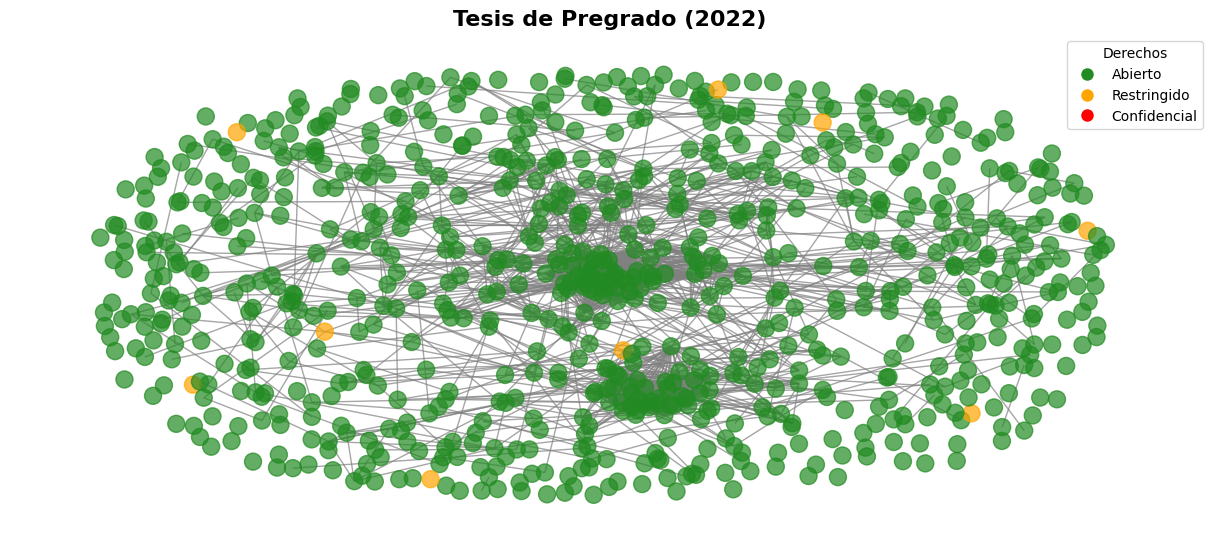

Graph with 792 nodes and 2362 edges


In [ ]:
#pos = nx.kamada_kawai_layout(G1)
pos = nx.spring_layout(G1_3, k=0.15, iterations=20)
# k controls the distance between the nodes and varies between 0 and 1
# iterations is the number of times simulated annealing is run
# default k=0.1 and iterations=50

#Colores a los nodos según los derechos (right)
node_colors = []
for node in G1_3.nodes:
    if G1_3.nodes[node]['right'] == 'openAccess':
        node_colors.append('forestgreen')
    elif G1_3.nodes[node]['right'] == 'closedAccess':
        node_colors.append('red')
    elif G1_3.nodes[node]['right'] == 'embargoedAccess':
        node_colors.append('orange')

plt.figure(figsize=(12, 5))
nx.draw(G1_3, pos, with_labels=False, node_color=node_colors, font_size=8, font_color='black', node_size=150, edge_color='gray', alpha=0.7)

legend_labels = {"Abierto": 'forestgreen', "Restringido": 'orange', "Confidencial": 'red'}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in legend_labels.items()]
plt.legend(handles=legend_handles, title='Derechos', loc='upper right')

plt.title("Tesis de Pregrado (2022)", fontsize=16, fontweight='bold')
#plt.suptitle("Tesis de Pregrado, año 2022", fontsize=14)

plt.show()
print (G1_3)

In [ ]:
num_nodes = len(G1_3.nodes)
print(f"Número total de nodos: {num_nodes}")
num_edges = len(G1_3.edges)
print(f"Número total de aristas: {num_edges}")
# Coeficiente de agrupamiento
clustering_coefficient = nx.average_clustering(G1_3)
print(f"Coeficiente de agrupamiento: {clustering_coefficient}")
# Distancia promedio entre nodos
average_degree = sum(dict(G1_3.degree()).values()) / num_nodes
#print(f"Grado promedio: {average_degree}")

Número total de nodos: 792
Número total de aristas: 2362
Coeficiente de agrupamiento: 0.3307174766775954


# Grafo 2: Tesis de Pregrado || Año  

In [ ]:
#Tesis Pregrado || Año: 2019-2021
filtros = df_thesis_pre[(df_thesis_pre['thesis_type'] == 'bachelorThesis') &
                        (df_thesis_pre['year'].between(2019, 2021))]


# Crea un nuevo DataFrame con las filas filtradas
df_thesis_Bachelor = pd.DataFrame(filtros)

In [ ]:
df_thesis_Bachelor.shape

(1885, 10)

In [ ]:
unique_right_values = df_thesis_Bachelor['year'].unique()
print(unique_right_values)

[2021 2020 2019]


In [ ]:
G2 = nx.Graph()

# Agrega nodos al grafo con atributos
for index, row in df_thesis_Bachelor.iterrows():
    # Utiliza expresiones regulares para dividir las palabras clave
    keywords = re.split(r',\s*', row['keyword'])
    node_data = {'title': row['title'], 'year': row['year'], 'university': row['university'], 'right': row['right'], 'keyword': keywords}
    G2.add_node(row['id'], **node_data)

# Crea conexiones basadas en palabras clave compartidas
for node1, node2 in combinations(G2.nodes, 2):
    if G2.has_node(node1) and G2.has_node(node2):
        keywords_i = set(G2.nodes[node1]['keyword'])
        keywords_j = set(G2.nodes[node2]['keyword'])

        # Verifica si comparten al menos una palabra clave específica
        if any(keyword in keywords_j for keyword in keywords_i):
            G2.add_edge(node1, node2)

In [ ]:
df_thesis_Bachelor['year'].value_counts()

2021    874
2019    604
2020    407
Name: year, dtype: int64

In [ ]:
print (G2)

Graph with 1885 nodes and 8066 edges


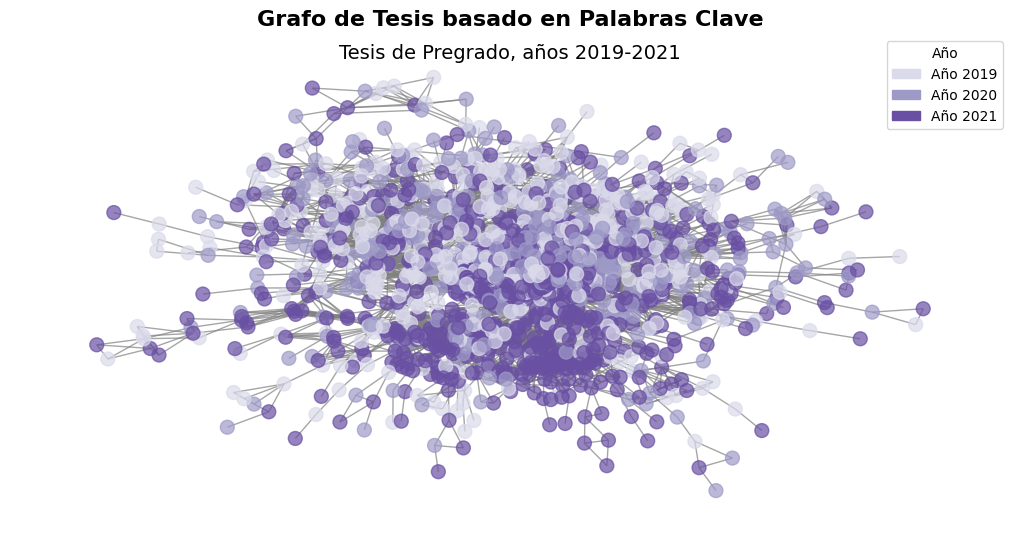

Graph with 1885 nodes and 8066 edges


In [ ]:
import matplotlib.patches as mpatches
#unique_years = sorted(set([G2.nodes[node]['year'] for node in G2.nodes]))
unique_years = set([G2.nodes[node]['year'] for node in G2.nodes])

color_map = sns.color_palette("Purples", len(unique_years))
node_colors = [color_map[list(unique_years).index(G2.nodes[node]['year'])] for node in G2.nodes]

pos = nx.kamada_kawai_layout(G2)
#fruchterman_reingold_layout

plt.figure(figsize=(10, 5))
nx.draw(G2, pos, with_labels=False, node_color=node_colors, font_size=8, node_size=100, edge_color='gray', alpha=0.7)

legend_labels = [mpatches.Patch(color=color, label=f'Año {year}') for year, color in zip(unique_years, color_map)]
plt.legend(handles=legend_labels, title='Año', loc='upper right')

plt.title("Grafo de Tesis basado en Palabras Clave", fontsize=16, fontweight='bold')
plt.suptitle("Tesis de Pregrado, años 2019-2021", fontsize=14)
plt.show()

print (G2)

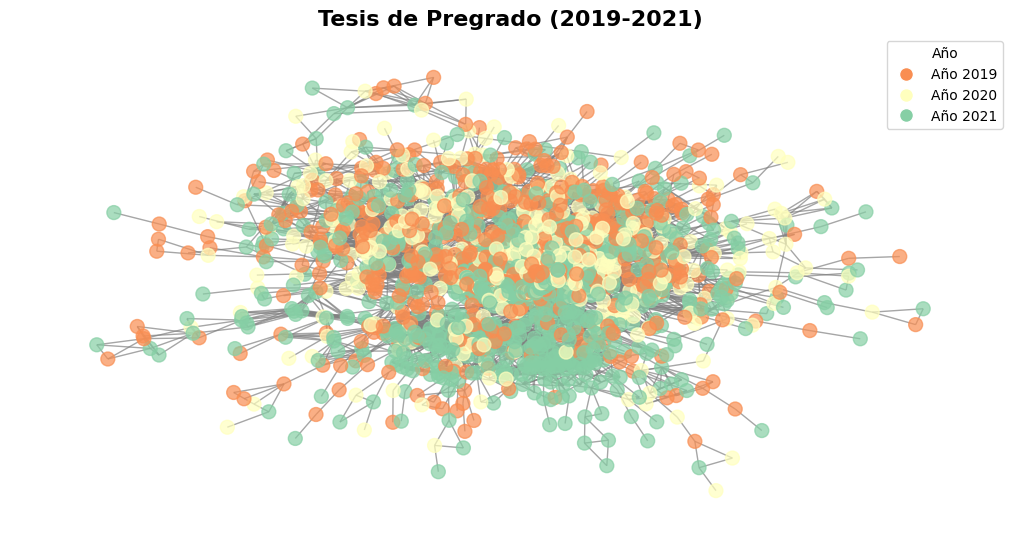

Graph with 1885 nodes and 8066 edges


In [ ]:
unique_years = sorted(set([G2.nodes[node]['year'] for node in G2.nodes]))

palette = sns.color_palette("Spectral", n_colors=len(unique_years)) #flare #Spectral
custom_color_dict = dict(zip(unique_years, palette))
node_colors = [custom_color_dict[G2.nodes[node]['year']] for node in G2.nodes]

pos = nx.kamada_kawai_layout(G2)

#Grafo
plt.figure(figsize=(10, 5))
nx.draw(G2, pos, with_labels=False, node_color=node_colors, font_size=8, node_size=100, edge_color='gray', alpha=0.7)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Año {year}') for year, color in custom_color_dict.items()]
plt.legend(handles=legend_handles, title='Año', loc='upper right')

plt.title("Tesis de Pregrado (2019-2021)", fontsize=16, fontweight='bold')
#plt.suptitle("Tesis de Pregrado, años 2019-2021", fontsize=14)

plt.show()
#print (G2)

In [ ]:
num_nodes = len(G2.nodes)
print(f"Número total de nodos: {num_nodes}")
num_edges = len(G2.edges)
print(f"Número total de aristas: {num_edges}")
# Coeficiente de agrupamiento
clustering_coefficient = nx.average_clustering(G2)
print(f"Coeficiente de agrupamiento: {clustering_coefficient}")
#Grado promedio
#average_degree = sum(dict(G2.degree()).values()) / num_nodes
#print(f"Grado promedio: {average_degree}")
# Diámetro

Número total de nodos: 1885
Número total de aristas: 8066
Coeficiente de agrupamiento: 0.46771031020081977


##Grafo 3: Bachelor 2022: Keyword más usado

In [ ]:
#Tesis Pregrado || Año: 2019-2021
filtros = df_thesis_pre[(df_thesis_pre['thesis_type'] == 'bachelorThesis') &
                        (df_thesis_pre['year']==2022)]


# Crea un nuevo DataFrame con las filas filtradas
df_thesis_Bachelor_2 = pd.DataFrame(filtros)

In [ ]:
df_thesis_Bachelor_2.shape

(792, 10)

In [ ]:
#Keyword más común
all_keywords = [keyword.strip() for sublist in df_thesis_Bachelor_2['keyword'] for keyword in sublist.split(',')]

# Calcula la frecuencia de cada keyword
keyword_counts = Counter(all_keywords)
most_common_keyword = keyword_counts.most_common(1)
most_common_keywords_5 = keyword_counts.most_common(5)

print("Keyword más usada del 2022:", most_common_keyword)
print("Top 5 keywords más usadas:", most_common_keywords_5)

Keyword más usada del 2022: [('Infecciones por coronavirus', 44)]
Top 5 keywords más usadas: [('Infecciones por coronavirus', 44), ('Scrum (Desarrollo de software para computadora)', 31), ('Estudiantes universitarios', 15), ('Actividad motora', 8), ('Estudiantes universitarios - Actitudes', 8)]


In [ ]:
df_coronavirus = df_thesis_Bachelor_2[df_thesis_Bachelor_2['keyword'].apply(lambda keywords: any('coronavirus' in keyword.lower() for keyword in keywords.split(',')))]

In [ ]:
#df_coronavirus = pd.concat([df_coronavirus, df_covid], ignore_index=True)

In [ ]:
unique_right_values = df_coronavirus['keyword'].unique()
print(unique_right_values)

['Infecciones por coronavirus, Pandemia, Tomografía computarizada por rayos X'
 'Depresión, Pandemia, Infecciones por coronavirus, Adultos'
 'Pandemia, Comunicación, Infecciones por coronavirus'
 'Bibliometría, Infecciones por coronavirus, Enfermedades por virus'
 'Radiografía médica, Infecciones por coronavirus'
 'Infecciones por coronavirus, Odontólogos, Ambiente de trabajo'
 'Infecciones por coronavirus, SARS-CoV-2 (Virus), Medicamentos - Prescripción'
 'Fibra hasta la casa (FTTH), Fibra óptica, Infecciones por coronavirus'
 'Anemia, Infecciones por coronavirus'
 'Pseudomonas aeruginosa, Modalidades de secreciones y excreciones, Secreciones corporales, Infecciones por coronavirus'
 'Radiología, Infecciones por coronavirus'
 'Conocimento, Medicina preventiva, Infecciones por coronavirus'
 'Recursos de información, Bibliotecas - Tecnología de la información, Servicios de información, Infecciones por coronavirus'
 'Infecciones por coronavirus, Antígenos'
 'Tórax - Tomografía, Neumonía 

In [ ]:
df_coronavirus = df_coronavirus.drop(df_coronavirus.loc[df_coronavirus['keyword'] == "Fibra hasta la casa (FTTH), Fibra óptica, Infecciones por coronavirus"].index)

In [ ]:
df_coronavirus.shape

(50, 10)

In [ ]:
G3 = nx.Graph()

# Agrega nodos al grafo con atributos
for index, row in df_coronavirus.iterrows():
    # Utiliza expresiones regulares para dividir las palabras clave
    keywords = re.split(r',\s*', row['keyword'])
    node_data = {'title': row['title'], 'year': row['year'], 'university': row['university'], 'right': row['right'], 'keyword': keywords}
    G3.add_node(row['id'], **node_data)

# Crea conexiones basadas en palabras clave compartidas
for node1, node2 in combinations(G3.nodes, 2):
    if G3.has_node(node1) and G3.has_node(node2):
        keywords_i = set(G3.nodes[node1]['keyword'])
        keywords_j = set(G3.nodes[node2]['keyword'])

        # Verifica si comparten al menos una palabra clave específica
        if any(keyword in keywords_j for keyword in keywords_i):
            G3.add_edge(node1, node2)

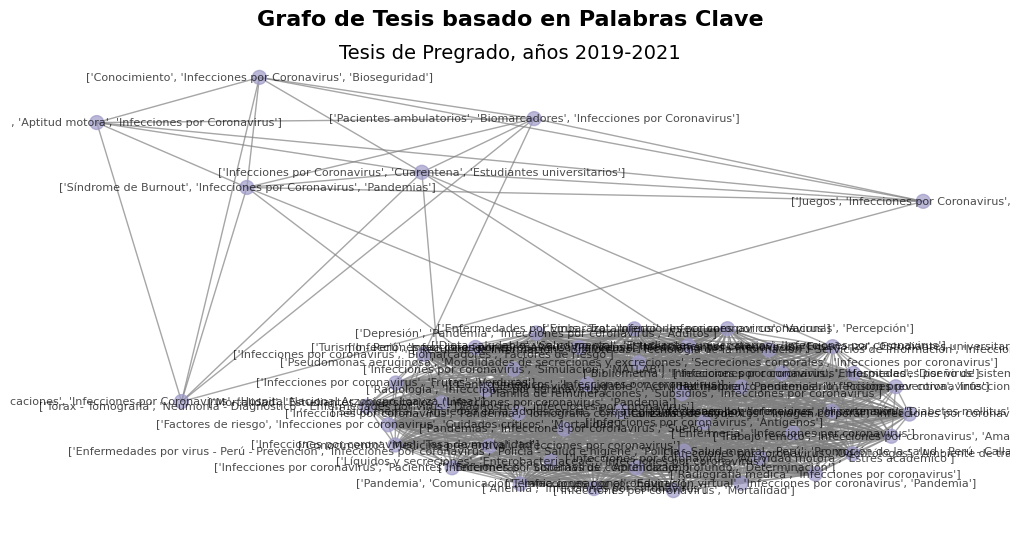

Graph with 50 nodes and 930 edges


In [ ]:
unique_years = set([G3.nodes[node]['year'] for node in G3.nodes])

color_map = sns.color_palette("Purples", len(unique_years))
node_colors = [color_map[list(unique_years).index(G3.nodes[node]['year'])] for node in G3.nodes]

#pos = nx.kamada_kawai_layout(G3)
#fruchterman_reingold_layout
pos = nx.spring_layout(G3,k=0.9)

plt.figure(figsize=(10, 5))
nx.draw(G3, pos, with_labels=True, labels=nx.get_node_attributes(G3, 'keyword'), node_color=node_colors, font_size=8, node_size=100, edge_color='gray', alpha=0.7)

plt.title("Grafo de Tesis basado en Palabras Clave", fontsize=16, fontweight='bold')
plt.suptitle("Tesis de Pregrado, años 2019-2021", fontsize=14)
plt.show()

print (G3)

In [ ]:
#all_keywords_coronavirus = [keyword.strip() for sublist in df_coronavirus['keyword'] for keyword in sublist.split(',')]
#all_keywords_coronavirus

In [ ]:
#coocurrences_coronavirus = Counter(combinations(set(all_keywords_coronavirus), 2))
#coocurrences_coronavirus

In [ ]:
G4 = nx.Graph()

# Agrega nodos al grafo con atributos
for index, row in df_coronavirus.iterrows():
    # Utiliza expresiones regulares para dividir las palabras clave
    keywords = re.split(r',\s*', row['keyword'])
    node_data = {'title': row['title'], 'year': row['year'], 'university': row['university'], 'right': row['right'], 'keyword': keywords}
    G4.add_node(row['id'], **node_data)

# Crea conexiones basadas en palabras clave compartidas
for node1, node2 in combinations(G4.nodes, 2):
    if G4.has_node(node1) and G4.has_node(node2):
        keywords_i = set(G4.nodes[node1]['keyword'])
        keywords_j = set(G4.nodes[node2]['keyword'])

        # Verifica si comparten al menos una palabra clave específica
        if any(keyword in keywords_j for keyword in keywords_i):
            G4.add_edge(node1, node2)

In [ ]:
print(G4)

Graph with 50 nodes and 930 edges


In [ ]:
#keyword_frequencies = df_coronavirus['keyword'].value_counts().to_dict()
#nx.set_node_attributes(G4, name='frequency', values=keyword_frequencies)

In [ ]:
# Calcular la frecuencia de cada palabra clave en el DataFrame
all_keywords = [keyword for keywords in df_coronavirus['keyword'] for keyword in keywords]
keyword_counts = Counter(all_keywords)

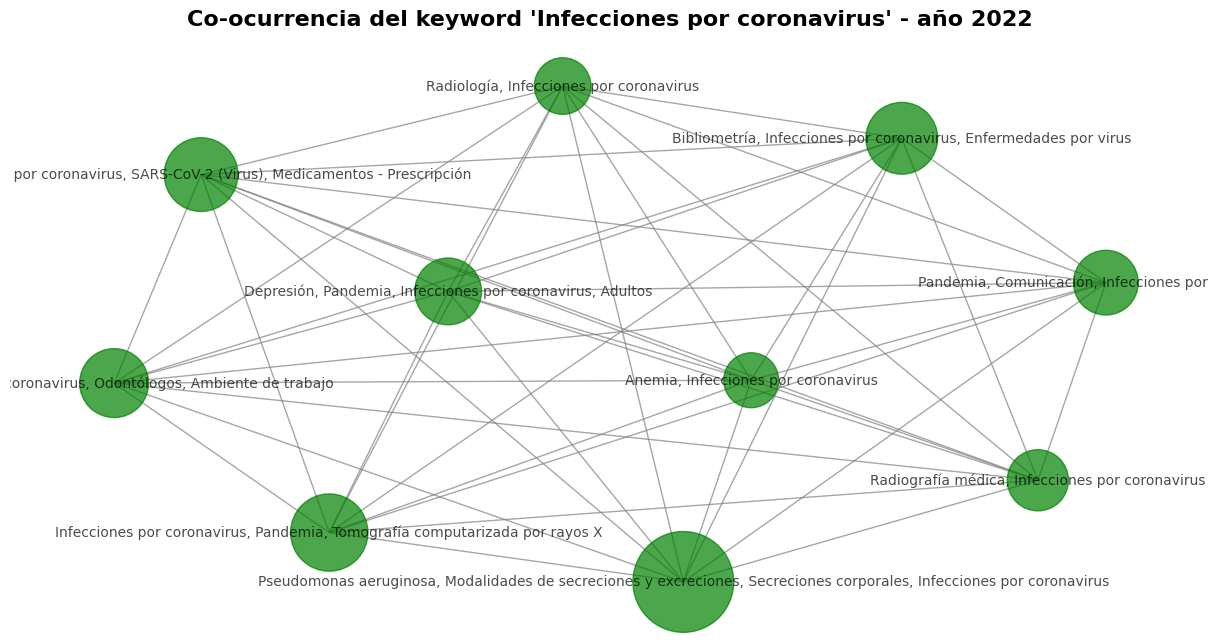

In [ ]:
G = nx.Graph()

for index, row in df_coronavirus.iterrows():
    node_id = row['id']
    keywords = row['keyword']
    weight = sum(keyword_counts[keyword] for keyword in keywords)
    G.add_node(node_id, keyword=keywords, weight=weight)

for node1, node2 in combinations(G.nodes, 2):
    if G.has_node(node1) and G.has_node(node2):
        keywords_i = set(G.nodes[node1]['keyword'])
        keywords_j = set(G.nodes[node2]['keyword'])

        # comparación de keywords
        if any(keyword in keywords_j for keyword in keywords_i):
            G.add_edge(node1, node2)

closeness_centrality = nx.closeness_centrality(G)
sorted_nodes = sorted(G.nodes(), key=lambda x: closeness_centrality[x], reverse=True)
top_nodes = sorted_nodes[:10]
G_subgraph = G.subgraph(top_nodes)

# Dibujar el grafo con pesos
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G_subgraph, k=0.5)
node_size = [0.2 * G_subgraph.nodes[node]['weight'] for node in G_subgraph.nodes]

nx.draw(G_subgraph, pos,
        with_labels=True,
        labels=nx.get_node_attributes(G_subgraph, 'keyword'),
        font_size=10,
        node_size=node_size,
        node_color='green',
        edge_color='gray',
        alpha=0.7)

plt.title("Co-ocurrencia del keyword 'Infecciones por coronavirus' - año 2022", fontsize=16, fontweight='bold')
plt.show()


In [ ]:
#G:grafo completo:
num_nodes = len(G.nodes)
print(f"Número total de nodos: {num_nodes}")
num_edges = len(G.edges)
print(f"Número total de aristas: {num_edges}")
# Coeficiente de agrupamiento
clustering_coefficient = nx.average_clustering(G)
print(f"Coeficiente de agrupamiento: {clustering_coefficient}")
# Distancia promedio entre nodos
average_shortest_path = nx.average_shortest_path_length(G)
print(f"Distancia promedio entre nodos: {average_shortest_path}")
# Grado promedio
average_degree = sum(dict(G.degree()).values()) / num_nodes
#print(f"Grado promedio: {average_degree}")
# Diámetro
diameter = nx.diameter(G)
print(f"Diámetro: {diameter}")

Número total de nodos: 10
Número total de aristas: 45
Coeficiente de agrupamiento: 1.0
Distancia promedio entre nodos: 1.0
Diámetro: 1


# Grafo de Tesis con keywords relacionadas al COVID-19

In [ ]:
#df_covid = df_thesis_pre[df_thesis_pre['keyword'].str.contains('covid|coronavirus|sars', case=False, regex=True)]
df_covid = df_thesis_pre[(df_thesis_pre['keyword'].str.contains('covid|coronavirus|sars', case=False, regex=True)) &
                         (df_thesis_pre['year'] >= 2021) & (df_thesis_pre['year'] <= 2022)]


In [ ]:
df_covid.shape

(76, 10)

In [ ]:
df_covid['year'].value_counts().sort_index()

2021    10
2022    66
Name: year, dtype: int64

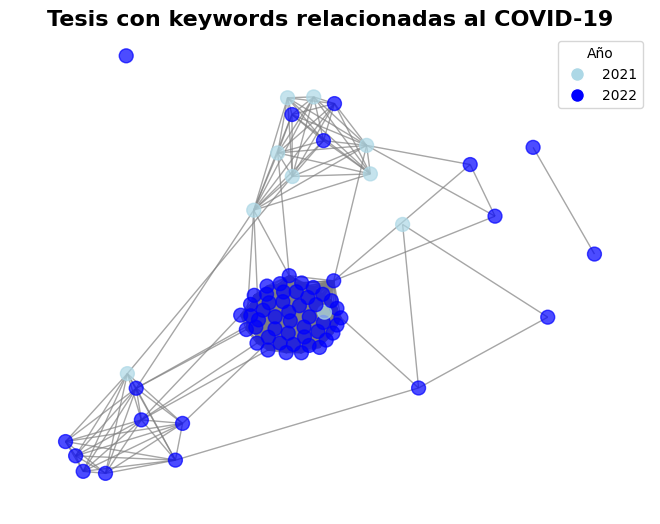

In [ ]:
G = nx.Graph()
for index, row in df_covid.iterrows():
    keywords = [keyword.strip() for keyword in row['keyword'].split(',')]
    node_data = {'year': row['year'], 'keywords': keywords}
    G.add_node(index, **node_data)

# Agregar conexiones basadas en palabras clave compartidas
for node1, node2 in combinations(G.nodes, 2):
    keywords_i = set(G.nodes[node1]['keywords'])
    keywords_j = set(G.nodes[node2]['keywords'])

    # Verificar si comparten al menos una palabra clave específica
    if any(keyword in keywords_j for keyword in keywords_i):
        G.add_edge(node1, node2)

# Asignar colores a los nodos según el atributo 'year'
node_colors = ['lightblue' if G.nodes[node]['year'] == 2021 else 'blue' for node in G.nodes]

# Dibujar el grafo
pos = nx.spring_layout(G,k=0.5)
nx.draw(G, pos, with_labels=False, node_color=node_colors, font_size=8, node_size=100, edge_color='gray', alpha=0.7)

# Leyenda
legend_labels = {2021: 'lightblue', 2022: 'blue'}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in legend_labels.items()]
plt.legend(handles=legend_handles, title='Año', loc='upper right')

# Mostrar el grafo
plt.title("Tesis con keywords relacionadas al COVID-19", fontsize=16, fontweight='bold')
#plt.suptitle("Nodos coloreados por año", fontsize=14)
plt.show()

In [ ]:
num_nodes = len(G.nodes)
print(f"Número total de nodos: {num_nodes}")
num_edges = len(G.edges)
print(f"Número total de aristas: {num_edges}")
# Coeficiente de agrupamiento
clustering_coefficient = nx.average_clustering(G)
print(f"Coeficiente de agrupamiento: {clustering_coefficient}")
# Distancia promedio entre nodos
# Grado promedio
average_degree = sum(dict(G.degree()).values()) / num_nodes
print(f"Grado promedio: {average_degree}")
# Diámetro

Número total de nodos: 76
Número total de aristas: 1281
Coeficiente de agrupamiento: 0.9057680708156162
Grado promedio: 33.71052631578947


In [ ]:
# Frecuencia de cada palabra clave en el DataFrame
#all_keywords = [keyword for keywords in df_covid['keyword'] for keyword in keywords]
#keyword_counts = Counter(all_keywords)

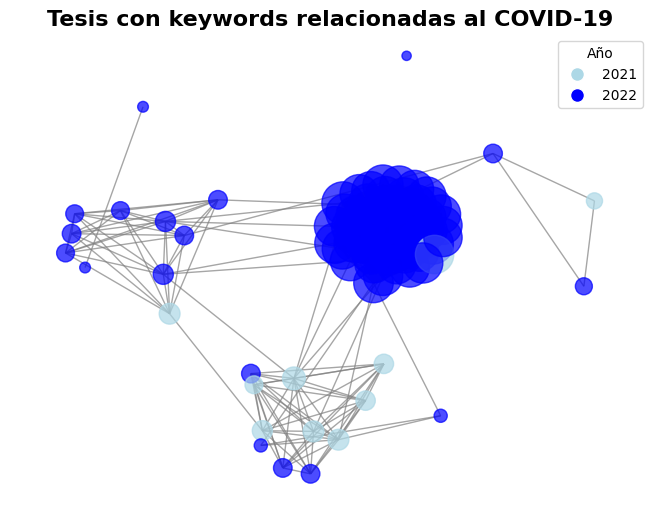

In [ ]:
#Conteo de palabras clave para el valorponderado (frecuencia)
all_keywords = [keyword.strip() for sublist in df_covid['keyword'].apply(lambda x: x.split(',')) for keyword in sublist]
keyword_counts = Counter(all_keywords)

#Grafo con ponderación en nodos
G = nx.Graph()
for index, row in df_covid.iterrows():
    keywords = [keyword.strip() for keyword in row['keyword'].split(',')]

    #Ponderación del nodo
    node_weight = sum(keyword_counts[keyword] for keyword in keywords)

    node_data = {'year': row['year'], 'keywords': keywords, 'weight': node_weight}
    G.add_node(index, **node_data)

#Conexiones (según palabras clave en común):
for node1, node2 in combinations(G.nodes, 2):
    keywords_i = set(G.nodes[node1]['keywords'])
    keywords_j = set(G.nodes[node2]['keywords'])

    if any(keyword in keywords_j for keyword in keywords_i):
        G.add_edge(node1, node2)

#Colores de los nodos
node_colors = ['lightblue' if G.nodes[node]['year'] == 2021 else 'blue' for node in G.nodes]

#Tamaños de los nodos según ponderación
node_sizes = [G.nodes[node]['weight'] * 15 for node in G.nodes]

#Grafo:
pos = nx.spring_layout(G, k=0.7)
nx.draw(G, pos, with_labels=False, node_color=node_colors, font_size=8, node_size=node_sizes, edge_color='gray', alpha=0.7)

legend_labels = {2021: 'lightblue', 2022: 'blue'}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in legend_labels.items()]
plt.legend(handles=legend_handles, title='Año', loc='upper right')

plt.title("Tesis con keywords relacionadas al COVID-19", fontsize=16, fontweight='bold')
plt.show()

In [ ]:
num_nodes = len(G.nodes)
print(f"Número total de nodos: {num_nodes}")
num_edges = len(G.edges)
print(f"Número total de aristas: {num_edges}")
# Coeficiente de agrupamiento
clustering_coefficient = nx.average_clustering(G)
print(f"Coeficiente de agrupamiento: {clustering_coefficient}")
# Distancia promedio entre nodos
# Grado promedio
average_degree = sum(dict(G.degree()).values()) / num_nodes
print(f"Grado promedio: {average_degree}")
# Diámetro

Número total de nodos: 76
Número total de aristas: 1281
Coeficiente de agrupamiento: 0.9057680708156162
Grado promedio: 33.71052631578947
